In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from model.pspunet import pspunet
from road_segmetation.data_loader.display import create_mask
import math


gpus = tf.config.experimental.list_physical_devices('GPU')

IMG_WIDTH = 480
IMG_HEIGHT = 272
n_classes = 7

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=700)])
    except RuntimeError as e:
        print(e)
        
model = pspunet((IMG_HEIGHT, IMG_WIDTH ,3), n_classes)
model.load_weights("pspunet_weight.h5")

ANGLE_CLASS = 15


ModuleNotFoundError: No module named 'road_segmetation'

In [2]:
def distance(value):
    dist = math.sqrt(value[0]*value[0] + value[1]*value[1] + value[2]*value[2])
    return (dist, dist, dist)

def point2dist(arr):    #0.25초정도 소요 
    arr = np.reshape(arr, (270*480,3))
    dist = list(map(lambda value : distance(value) , arr))  #여기 더 빠른 로직있으면 변경해주세용
    dist= np.array(dist)
    dist = np.reshape(dist, (270,480,3))
    #dist[(dist<0.1)] = 0 
    dist[(dist>50)] = 50
    return dist



def seg_predict(img):
    frame = cv2.resize(img,(480,272))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame/=255
    pre = model.predict(frame[tf.newaxis, ...])
    pre = create_mask(pre).numpy()
    frame2 = frame/2
    #frame2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR)
    frame2[(pre==1).all(axis=2)] += [0, 0, 0] #""bike_lane_normal", "sidewalk_asphalt", "sidewalk_urethane""
    frame2[(pre==2).all(axis=2)] += [0.5, 0.5,0] # "caution_zone_stairs", "caution_zone_manhole", "caution_zone_tree_zone", "caution_zone_grating", "caution_zone_repair_zone"]
    frame2[(pre==3).all(axis=2)] += [0.2, 0.7, 0.5] #"alley_crosswalk","roadway_crosswalk"
    frame2[(pre==4).all(axis=2)] += [0, 0.5, 0.5] #"braille_guide_blocks_normal", "braille_guide_blocks_damaged"
    frame2[(pre==5).all(axis=2)] += [0, 0, 0.5] #"roadway_normal","alley_normal","alley_speed_bump", "alley_damaged""
    frame2[(pre==6).all(axis=2)] += [0.5, 0, 0] #"sidewalk_blocks","sidewalk_cement" , "sidewalk_soil_stone", "sidewalk_damaged","sidewalk_other"
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    frame[(pre!=6).all(axis=2)]=0
    
    frame = cv2.resize(frame,(480,270))
    frame2 = cv2.resize(frame2,(480,270))

    return frame2, frame


def selly_vision(max_dist, img, point_cloud):
    start_time= time.time()
    img_copy = img.copy()
    seg, side = seg_predict(img_copy)
    depth = point2dist(point_cloud)
    img_copy[(depth>max_dist)]= 0
    side[(img_copy==0)] = 0
    print(time.time() -start_time)
    return side

def decision_path(angle, obstacle_angle):
    obstacle_angle = vision_angle(obstacle_angle)
    angle_dict = {}
    for i in range(1,ANGLE_CLASS+1):
        try:
            angle_dict[i] = round(len(angle[angle==i])/len(obstacle_angle[obstacle_angle==i]),3)
        except:
            angle_dict[i] = 0
    return angle_dict

def angle_value(x, y):
    myradians = math.atan2(x[1]-y[1], x[0]-y[0])        
    mydegrees = math.degrees(myradians)
    return mydegrees + 90

def angle_dict():
    angle={}
    center = (270,240)
    for i in range(270):
        for j in range(480):
            angle[str(i)+str(j)] = angle_value(center,(i, j))//(180/ANGLE_CLASS) + 1
    return angle

def vision_angle(img):
    img_cp = img.copy()
    for i in range(270):
        for j in range(480):
            if img_cp[i,j,0]==0:
                continue
            else:
                img_cp[i,j]= angle[str(i)+str(j)]

    return img_cp

def RGB(frame): 
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def arrow_image(img, angle, obstacle_angle):
    path_dict = decision_path(angle, obstacle_angle)
    center = (240, 270)
    for i in range(ANGLE_CLASS-1):
        if path_dict[i+1] > 0.95:
            x = 100 * math.cos(math.radians((180/ANGLE_CLASS)*i+ (180/ANGLE_CLASS)/2));
            y = 100 * math.sin(math.radians((180/ANGLE_CLASS)*i+ (180/ANGLE_CLASS)/2));
            cv2.arrowedLine(img, center , (240+int(x),270-int(y)), (0,255,0), 3, tipLength=0.2 )
    return img

angle = angle_dict()


In [4]:
data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

In [ ]:
for idx in range(500,1101):
    max_dist = 2.5
    #idx = 1072
    img_copy = img[idx].copy()
    seg_img, side_walk = seg_predict(img_copy)
    depth = point2dist(point_cloud[idx])
    side = side_walk.copy()

    plt.figure(figsize=(20,12))
    plt.subplot(3,3,1)
    plt.axis("off")
    plt.title("img")
    plt.imshow(RGB(img[idx]/255))

    plt.subplot(3,3,2)
    plt.axis("off")
    plt.title("depth")
    plt.imshow(depth/50)

    plt.subplot(3,3,3)
    plt.axis("off")
    plt.title("segementation")
    plt.imshow(RGB(seg_img))

    plt.subplot(3,3,4)
    plt.axis("off")
    plt.title("only sidewalk")
    plt.imshow(RGB(side))

    plt.subplot(3,3,5)
    plt.axis("off")
    plt.title( "img in "+str(max_dist)+"M")
    img_copy[(depth>max_dist)]= 0
    plt.imshow(RGB(img_copy/255))

    plt.subplot(3,3,6)
    plt.axis("off")
    plt.title( "only sidewalk in "+str(max_dist)+"M")
    side[(img_copy==0)] = 0
    plt.imshow(RGB(side))

    plt.subplot(3,3,7)
    plt.axis("off")
    plt.title( "obstacle in "+str(max_dist)+"M")
    imm = img[idx].copy()
    imm[(side_walk==0) & (img_copy!=0)] = 0
    plt.imshow(imm)

    angle_img = vision_angle(side)

    plt.subplot(3,3,8)
    plt.axis("off")
    plt.title( "angle")
    imm = img[idx].copy()
    imm[(side_walk==0) & (img_copy!=0)] = 0
    imm[angle_img!=0] = angle_img[angle_img!=0]/ANGLE_CLASS
    plt.imshow(imm)

    plt.subplot(3,3,9)
    plt.axis("off")
    plt.title( "selly_vision")

    imm = img[idx].copy()
    imm[~((side_walk==0) & (img_copy!=0))] = 0
    imm[angle_img!=0] = angle_img[angle_img!=0]/ANGLE_CLASS
    plt.imshow(RGB(arrow_image(img[idx].copy(),angle_img, imm)/255))
    plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(idx))
    print(idx)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


235


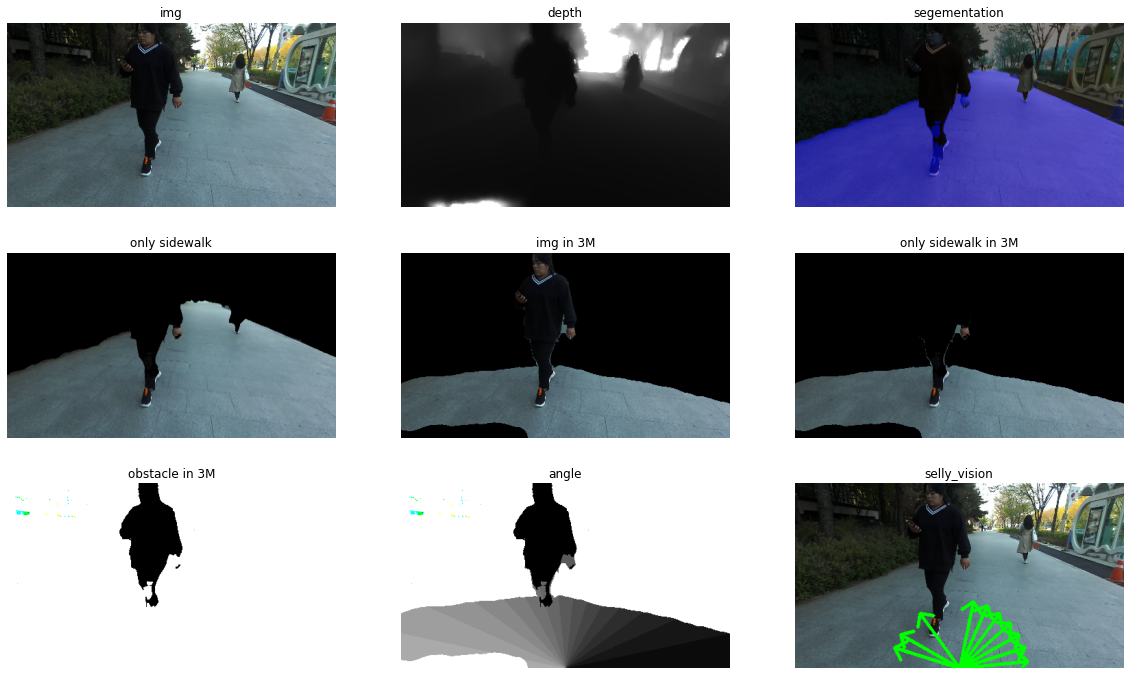

In [12]:
max_dist = 3
idx = 235
img_copy = img[idx].copy()
seg_img, side_walk = seg_predict(img_copy)
depth = point2dist(point_cloud[idx])
side = side_walk.copy()

plt.figure(figsize=(20,12))
plt.subplot(3,3,1)
plt.axis("off")
plt.title("img")
plt.imshow(RGB(img[idx]/255))

plt.subplot(3,3,2)
plt.axis("off")
plt.title("depth")
plt.imshow(depth/50)

plt.subplot(3,3,3)
plt.axis("off")
plt.title("segementation")
plt.imshow(RGB(seg_img))

plt.subplot(3,3,4)
plt.axis("off")
plt.title("only sidewalk")
plt.imshow(RGB(side))

plt.subplot(3,3,5)
plt.axis("off")
plt.title( "img in "+str(max_dist)+"M")
img_copy[(depth>max_dist)]= 0
plt.imshow(RGB(img_copy/255))

plt.subplot(3,3,6)
plt.axis("off")
plt.title( "only sidewalk in "+str(max_dist)+"M")
side[(img_copy==0)] = 0
plt.imshow(RGB(side))

plt.subplot(3,3,7)
plt.axis("off")
plt.title( "obstacle in "+str(max_dist)+"M")
imm = img[idx].copy()
imm[(side_walk==0) & (img_copy!=0)] = 0
plt.imshow(imm)

angle_img = vision_angle(side)


plt.subplot(3,3,8)
plt.axis("off")
plt.title( "angle")
imm = img[idx].copy()
imm[(side_walk==0) & (img_copy!=0)] = 0
imm[angle_img!=0] = angle_img[angle_img!=0]/(ANGLE_CLASS*1.5)
plt.imshow(imm)

plt.subplot(3,3,9)
plt.axis("off")
plt.title( "selly_vision")

imm = img[idx].copy()
imm[~((side_walk==0) & (img_copy!=0))] = 0
imm[angle_img!=0] = angle_img[angle_img!=0]/ANGLE_CLASS
plt.imshow(RGB(arrow_image(img[idx].copy(),angle_img, imm)/255))
plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(idx))
print(idx)


In [45]:
#동영상 녹화
import os 

vision_img_list = os.listdir("selly_vision_video/")

max_dist = 5
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('selly_vision.mp4', fourcc, 10.0, (1440, 864))
vision_img_list.sort()
for idx in range(1101):
    start_time = time.time()
    vision_img = cv2.imread("selly_vision_video/"+vision_img_list[idx])
    out.write(vision_img)
    print(time.time()-start_time)
    
out.release()



0.03914499282836914
0.022417068481445312
0.02170848846435547
0.021787166595458984
0.021449804306030273
0.02160930633544922
0.021755695343017578
0.021754741668701172
0.021676063537597656
0.021450281143188477
0.02191901206970215
0.02180314064025879
0.023087501525878906
0.0216367244720459
0.020771265029907227
0.020688772201538086
0.020798444747924805
0.02072286605834961
0.02075052261352539
0.020627498626708984
0.020948171615600586
0.02070021629333496
0.02052021026611328
0.020459651947021484
0.02145671844482422
0.0206143856048584
0.02039504051208496
0.02053999900817871
0.02061772346496582
0.020548343658447266
0.020425796508789062
0.02045154571533203
0.02045130729675293
0.020557641983032227
0.020464658737182617
0.02055191993713379
0.021399736404418945
0.020657777786254883
0.020512819290161133
0.02061915397644043
0.02065443992614746
0.0207216739654541
0.020658493041992188
0.020669937133789062
0.02072930335998535
0.021422147750854492
0.021779537200927734
0.021701574325561523
0.022124052047729

0.020307064056396484
0.020226240158081055
0.0200197696685791
0.020101308822631836
0.019986629486083984
0.020143985748291016
0.020169734954833984
0.021039485931396484
0.020148754119873047
0.019970417022705078
0.01984262466430664
0.020436763763427734
0.021343231201171875
0.02083563804626465
0.021006107330322266
0.020872831344604492
0.020857810974121094
0.020932674407958984
0.020940542221069336
0.02179551124572754
0.021289587020874023
0.020725488662719727
0.020291566848754883
0.02019643783569336
0.020108461380004883
0.019997358322143555
0.020246028900146484
0.020157337188720703
0.02006077766418457
0.020117759704589844
0.020061731338500977
0.021106481552124023
0.02019786834716797
0.020112037658691406
0.01999807357788086
0.02006220817565918
0.02007460594177246
0.020040273666381836
0.01996016502380371
0.020203351974487305
0.020479202270507812
0.02043938636779785
0.020379304885864258
0.02096247673034668
0.020326852798461914
0.020117759704589844
0.02010369300842285
0.020186185836791992
0.02013

0.020494937896728516
0.020211219787597656
0.020333290100097656
0.020330190658569336
0.020430803298950195
0.020520925521850586
0.020514726638793945
0.020259857177734375
0.02047872543334961
0.021085500717163086
0.020671844482421875
0.020485877990722656
0.020652055740356445
0.02053689956665039
0.020431995391845703
0.020366430282592773
0.020362377166748047
0.020505666732788086
0.020393848419189453
0.020432710647583008
0.020621299743652344
0.02106642723083496
0.020437002182006836
0.020266294479370117
0.02022862434387207
0.019940853118896484
0.020102500915527344
0.020188093185424805
0.019995689392089844
0.02015066146850586
0.021107196807861328
0.020862579345703125
0.021351337432861328
0.021770238876342773
0.021291017532348633
0.021233558654785156
0.021522998809814453
0.02117013931274414
0.02142930030822754
0.021484375
0.02108144760131836
0.020557641983032227
0.02039933204650879
0.02015066146850586
0.02045917510986328
0.02095198631286621
0.02036452293395996
0.020260095596313477
0.020014524459